# Using the SPARQL1.1 query language

Working with Semantic Web knowledge graphs can be a daunting prospect for a newcomer.  Having lots of new acronyms and terms to learn and understand – like RDF, SPARQL and knowledge graph – can been seen as a barrier of entry for these powerful technologies. 

In reality, Semantic Web knowledge graph databases are a very easy and intuitive way to understand, record and traverse data. In our opinion, much easier to use than relational databases. 

## Prerequisites

This guide will show you how easy it is to use the powerful features of RDF and SPARQL, and as long as you have a general understanding of how to use a REST API, and some experience with some other kind of database in the past, SQL or NoSQL, you will be able to follow along easily.

*N.B.* You do *NOT* need to understand what RDF, SPARQL, Semantic Web or Linked Data are in order to get benefit from these technologies, or this guide. Cool, huh?

### 1. Formatting data, ready to store, in a very human way

Using a graph database such as Amazon Neptune you can store data in a very easy to understand format: RDF. Don’t worry about exactly what RDF is, just that it tries to represent data in the form of “statements”.

For example, let’s make the following statement in natural language:

`“Charlie knows Ora”`

This statement makes a lot of sense to us as humans. So how do we represent this data in RDF?  The following is 100% valid RDF (and don’t worry about the line with *@base* for now, we will get to that later):

`@base <http://example.org/> .
:Charlie :knows :Ora`

So you see... very easy so far!

But one statement alone doesn’t give us much information. We make many statements to make sense of our world, so let’s add a bit more information to our knowledge base, or – dare we say – *Knowledge Graph*:

`@base <http://example.org/> .
:Charlie :knows   :Ora
:Ora     :knows   :Charlie
:Ora     :livesIn :USA
:Charlie :livesIn :UK`

### These statements form a graph:

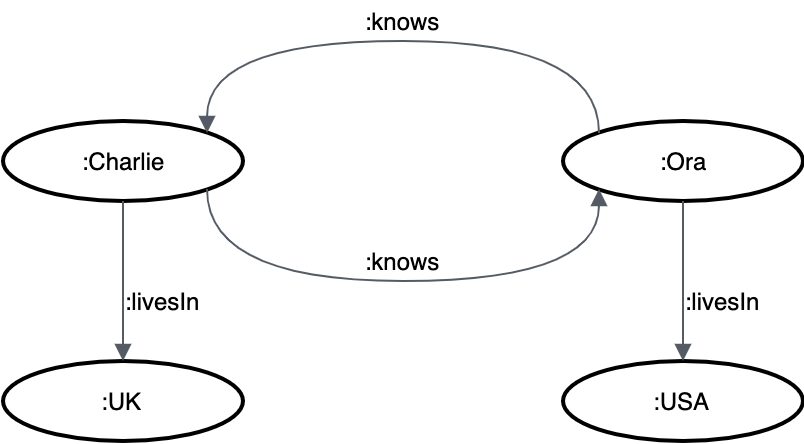

### 2. Insert your statements using a "SPARQL" query 

To insert your data, simply wrap your statements inside an INSERT clause, as shown below. This query is executable, and will insert your data into your Amazon Neptune cluster. Execute the following cell (ctrl+enter) to insert the data:

In [29]:
%%sparql
PREFIX : <http://example.org/> 

INSERT DATA {
    :Charlie :knows   :Ora .
    :Ora     :knows   :Charlie .
    :Ora     :livesIn :USA .
    :Charlie :livesIn :UK .
}

To add more data, you simply issue another INSERT query. Let’s add a few more statements into the database, just to allow us later to show some more examples of how to query the data:

In [ ]:
%%sparql
PREFIX : <http://example.org/> 

INSERT DATA {
    :Charlie :knows   :Ian
    :Ian     :knows   :Charlie
    :Ian     :livesIn :UK
}

Our graph will now look like this:

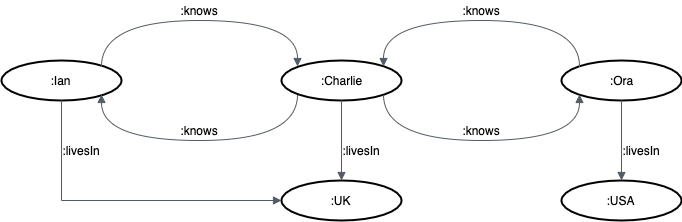

### 3. How to retrieve your data

Let’s see what kind of questions we can ask our little graph so far. In their simplest form, SPARQL queries are like RDF statements, with the things you are asking for replaced with variables (these are simply names preceded by a question mark). For example, this is a variable: 

`?person.`

Question: “Who does Charlie know?” ... 

In [ ]:
%%sparql

PREFIX : <http://example.org/> 

SELECT ?person
{
    :Charlie :knows ?person .
}

A SELECT query specifies what variables are returned as part of the solution. You can return any number of variables, and there can be any number of solutions (including zero). Think of the solutions as rows and the variables as columns; note that this is similar to how SQL query results are returned. Given our sample graph, we have only one solution:

`:Ora.`

Question: “Who lives in the USA?” ...

In [ ]:
%%sparql 

PREFIX : <http://example.org/> 

SELECT ?person
{
    ?person :livesIn :USA .
}

Question: "Who does Charlie know who lives in the USA?" ...

In [ ]:
%%sparql

PREFIX : <http://example.org/> 

SELECT ?person
{
    :Charlie :knows   ?person .
    ?person  :livesIn :USA .
}

Normally, all the statements with variables (they are called “basic graph patterns” – BGP for short – in SPARQL) have to be satisfied using the same selection of variable values. So in the above query, the `?person` in the first BGP has to be the same `?person` appearing in the second BGP.

You can think of the query as sort of a “template” you have to match against the graph. This here would be a graphical representation of the query:

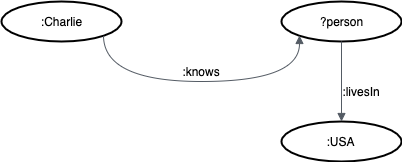

Question: "Who does Charlie know who lives in the same country as Charlie?" ...

In [ ]:
%%sparql 

PREFIX : <http://example.org/> 

SELECT ?person
{
    :Charlie :knows   ?person .
    :Charlie :livesIn ?country .
    ?person  :livesIn ?country .
}

In this query we introduce a new variable, ?country, but it is not part of the results we return, we merely use it within the query to get to the answer we are looking for.

Just like in the previous example, we can imagine a graph that illustrates the query:

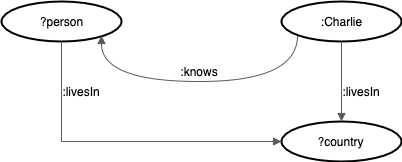

Note that this last example could also be written like this:

In [ ]:
%%sparql

PREFIX : <http://example.org/> .

SELECT ?person
{
    :Charlie :knows ?person ; 
             :livesIn ?country .
             
    ?person  :livesIn ?country .
}

By using the semicolon to separate patterns we indicate that they are all about `:Charlie`. This is a shorthand technique that sometimes makes queries clearer and easier to write.

### 4. Filtering the response

Let’s insert a little more data into our graph:

In [ ]:
%%sparql 

PREFIX : <http://example.org/> 

INSERT DATA {
    :Charlie :age 37 .
    :Ian     :age 42 .
    :Ora     :age 29 .
}

Now we can introduce some filtering.

Question: "Does Charlie know anyone whose age is less than 30?" ...

In [ ]:
%%sparql 

PREFIX : <http://example.org/> 

SELECT ?person
{
    :Charlie :knows ?person .
    ?person  :age   ?age .
    FILTER (?age < 30)
}

This kind of a `FILTER` clause is basically a way to introduce additional logical constraints that the solution has to satisfy.

### 5. Optional and Union

#### OPTIONAL: 
     
OPTIONAL is used when you are not sure if a particular statement exists, but you still want to return the rest of the data, whether the OPTIONAL statement exists or not.

In this example, we want to return ALL the people who are Authors, and also list any papers that were written about "The Semantic Web". Without the OPTIONAL clause, the query would only return Authors who have published a paper about "The Semantic Web", and not those who haven’t.


`Consider the differences between the following two queries:`

1. Return all people who are Authors, whether they have published a paper about the Semantic Web or not is an OPTIONAL fact to the query, but we still want to include any papers that were published about the Semantic Web.

In [ ]:
%%sparql

PREFIX : <http://example.org/> 

SELECT ?person ?paper
{
    ?person a :Author     .
    
    OPTIONAL { 
        ?person :published ?paper ;
        ?paper  :about     :SemanticWeb
    }
    
}

*The result set:*
Containing all people who are Authors, and listing their publications if they made any about The Semantic Web 

| Person | Paper |
| :-- | :-- |
| :Ora | :ProgrammingSemanticWebApplications |
| :Ora | :TheSemanticWeb |
| :Charlie |  |
| :Ian |  |

2. Only return Authors who have published something about the Semantic Web, and list their papers. 

In [ ]:
%%sparql

PREFIX : <http://example.org/> 

SELECT ?person ?paper
{
    ?person a :Author     .
    
    ?person :published ?paper .
    ?paper  :about     :SemanticWeb
         
}

*The result set:*
By removing the OPTIONAL clause, we will only return people who have published a paper about the Semantic Web, as this statement is no longer OPTIONAL.

| Person | Paper |
| :-- | :-- |
| :Ora | :ProgrammingSemanticWebApplications |
| :Ora | :TheSemanticWeb |

#### UNION

UNION is used to aggregate results from two or more patterns. 

1. Aggregate the authors that have published either a paper about `:SemanticWeb` or about `:GraphDatabases` 

In [ ]:
%%sparql

PREFIX : <http://example.org/> 

SELECT ?person ?paper
{
    
    ?person a          :Author ;
            :published ?paper .
    
    {
        ?paper :about     :GraphDatabases
    }
    UNION 
    {
        ?paper :about     :SemanticWeb
    }
    
}

*The result set:*
We now have a UNION of papers published that are about either the Semantic Web or Graph Databases.

| Person | Paper |
| :-- | :-- |
| :Ora | :ProgrammingSemanticWebApplications |
| :Ora | :TheSemanticWeb |
| :Ian | :GraphDatabases |

### 6. GROUP BY

Execute the following query to insert all the data you need for this excercise:

In [ ]:
%%sparql

PREFIX : <http://example.org/> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

INSERT DATA 
{
    :Ian         a :Author     .
    :Charlie     a :Author     .
    :Ora         a :Author     .
    
    :Ora :published :TheSemanticWeb .
    :Ora :published :ProgrammingSemanticWebApplications .
    :Ian :published :GraphDatabases .
    
    :TheSemanticWeb                     :about     :SemanticWeb    .
    :ProgrammingSemanticWebApplications :about     :SemanticWeb    .
    :GraphDatabases                     :about     :GraphDatabases .
    
    :TheSemanticWeb                     :costs "20"^^xsd:integer .
    :ProgrammingSemanticWebApplications :costs "10"^^xsd:integer .
    :GraphDatabases                     :costs "25"^^xsd:integer .
    
}

GROUP BY in SPARQL operates very similarly to the SQL “GROUP BY” aggregator, in that it will group results based on a shared value or parameter.

1. Group by the author to return a list of people who have authored anything, without returning duplicate results.

In [ ]:
%%sparql

PREFIX : <http://example.org/> 

SELECT ?person 
{
    ?person a :Author .
    ?person :published ?paper . 
    
} group by ?person

*The result set:*
By grouping by the `“?person”` we ensure that we will only return one row per person.

| Person |
| :-- |
| :Ora |
| :Ora |
| :Ian |